# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Lab 10: Variational Autoencoders and GANs

**Harvard University**<br>
**Fall 2020**<br>
**Instructors:** Mark Glickman, Pavlos Protopapas, and Chris Tanner<br>
**Lab Instructors:** Chris Tanner and Eleni Angelaki Kaxiras<br>
**Content:** Srivatsan Srinivasan, Pavlos Protopapas, Chris Tanner 


<hr style="height:2pt">

In [1]:
# RUN THIS CELL TO PROPERLY HIGHLIGHT THE EXERCISES
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2019-CS109B/master/content/styles/cs109.css").text
HTML(styles)


In [2]:
# system libraries 
import sys
import warnings
import os
import glob
warnings.filterwarnings("ignore")

# image libraries
import cv2 # requires installing opencv (e.g., pip install opencv-python)
from imgaug import augmenters # requires installing imgaug (e.g., pip install imgaug)

# math/numerical libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.stats import norm
from sklearn.model_selection import train_test_split

import tensorflow as tf

### Part 2B: Adding CNNs and KL Divergence Loss
#### Generating new fashion!

In [3]:
batch_size = 16
latent_dim = 2  # Number of latent dimension parameters

# Encoder architecture: Input -> Conv2D*4 -> Flatten -> Dense
input_img = tf.keras.layers.Input(shape=(28, 28, 1))

x = tf.keras.layers.Conv2D(32,3,padding='same', activation='relu')(input_img)
x = tf.keras.layers.Conv2D(64,3,padding='same', activation='relu',strides=(2, 2))(x)
x = tf.keras.layers.Conv2D(64,3,padding='same', activation='relu')(x)
x = tf.keras.layers.Conv2D(64,3,padding='same', activation='relu')(x)

# need to know the shape of the network here for the decoder
shape_before_flattening = tf.keras.backend.int_shape(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)

# Two outputs, latent mean and (log)variance
z_mu = tf.keras.layers.Dense(latent_dim)(x)
z_log_sigma = tf.keras.layers.Dense(latent_dim)(x)

### Set up sampling function

In [4]:
# sampling function
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = tf.keras.backend.random_normal(shape=(tf.keras.backend.shape(z_mu)[0], latent_dim), mean=0., stddev=1.)
    return z_mu + tf.keras.backend.exp(z_log_sigma) * epsilon

# sample vector from the latent distribution
z = tf.keras.layers.Lambda(sampling)([z_mu, z_log_sigma])


### Encoder model

In [5]:
# instantiate encoder model
encoder = tf.keras.models.Model(input_img, [z_mu, z_log_sigma, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_1[0][0]                   
____________________________________________________________________________________________

### Setup Decoder Neural Network

In [6]:
#Decoder
latent_inputs = tf.keras.layers.Input(shape=(latent_dim,), name='z_sampling')

x = tf.keras.layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(latent_inputs)
x = tf.keras.layers.Reshape(shape_before_flattening[1:])(x)

# use Conv2DTranspose to reverse the conv layers from the encoder
x = tf.keras.layers.Conv2DTranspose(32, 3,
                           padding='same', 
                           activation='relu',
                           strides=(2, 2))(x)
x = tf.keras.layers.Conv2D(1, 3,
                  padding='same', 
                  activation='sigmoid')(x)

# instantiate decoder model
decoder = tf.keras.models.Model(latent_inputs, x, name='decoder')
decoder.summary()
outputs = decoder(encoder(input_img)[2])


Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 2)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 12544)             37632     
_________________________________________________________________
reshape (Reshape)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 1)         289       
Total params: 56,385
Trainable params: 56,385
Non-trainable params: 0
_________________________________________________________________


### Setup  VAE

In [7]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
VAE = tf.keras.Model(inputs=input_img, outputs=outputs)

# KL divergence
kl_loss = -5e-4 * tf.reduce_mean(1 + z_log_sigma - tf.square(z_mu) - tf.exp(z_log_sigma))

reconstruction_loss = tf.keras.losses.binary_crossentropy(input_img, outputs)
vae_loss = tf.keras.backend.mean(reconstruction_loss + kl_loss)

VAE.add_loss(vae_loss)
VAE.compile(optimizer=opt)
VAE.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 2), (None, 2 494244      input_1[0][0]                    
__________________________________________________________________________________________________
decoder (Model)                 (None, 28, 28, 1)    56385       encoder[1][2]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   320         input_1[0][0]                    
______________________________________________________________________________________________

### Train model

In [8]:
# get the data from keras - how convenient!
fashion_mnist = tf.keras.datasets.fashion_mnist

# load the data and split it into training and testing sets
(X_train, y_train),(X_test, y_test) = fashion_mnist.load_data()

# normalize the data by dividing with pixel intensity
# (each pixel is 8 bits so its value ranges from 0 to 255)
X_train, X_test = X_train / 255.0, X_test / 255.0

print(f'X_train shape: {X_train.shape}, X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}, and y_test shape: {y_test.shape}')

train_x = X_train.reshape(-1,28,28,1)  
val_x = X_test.reshape(-1,28,28,1) 


VAE.fit(x=train_x, y=None,
        shuffle=True,
        epochs=20,
        batch_size=batch_size,
        validation_data=(val_x, None))

X_train shape: (60000, 28, 28), X_test shape: (10000, 28, 28)
y_train shape: (60000,), and y_test shape: (10000,)
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 54s 898us/sample - loss: 0.4255 - val_loss: 0.3647
Epoch 2/20
60000/60000 [==============================] - 49s 824us/sample - loss: 0.3468 - val_loss: 0.3426
Epoch 3/20
60000/60000 [==============================] - 49s 818us/sample - loss: 0.3386 - val_loss: 0.3383
Epoch 4/20
60000/60000 [==============================] - 49s 821us/sample - loss: 0.3356 - val_loss: 0.3369
Epoch 5/20
60000/60000 [==============================] - 49s 815us/sample - loss: 0.3339 - val_loss: 0.3356
Epoch 6/20
60000/60000 [==============================] - 49s 819us/sample - loss: 0.3326 - val_loss: 0.3338
Epoch 7/20
60000/60000 [==============================] - 49s 820us/sample - loss: 0.3316 - val_loss: 0.3328
Epoch 8/20
60000/60000 [==============================] - 49s 819us/sampl

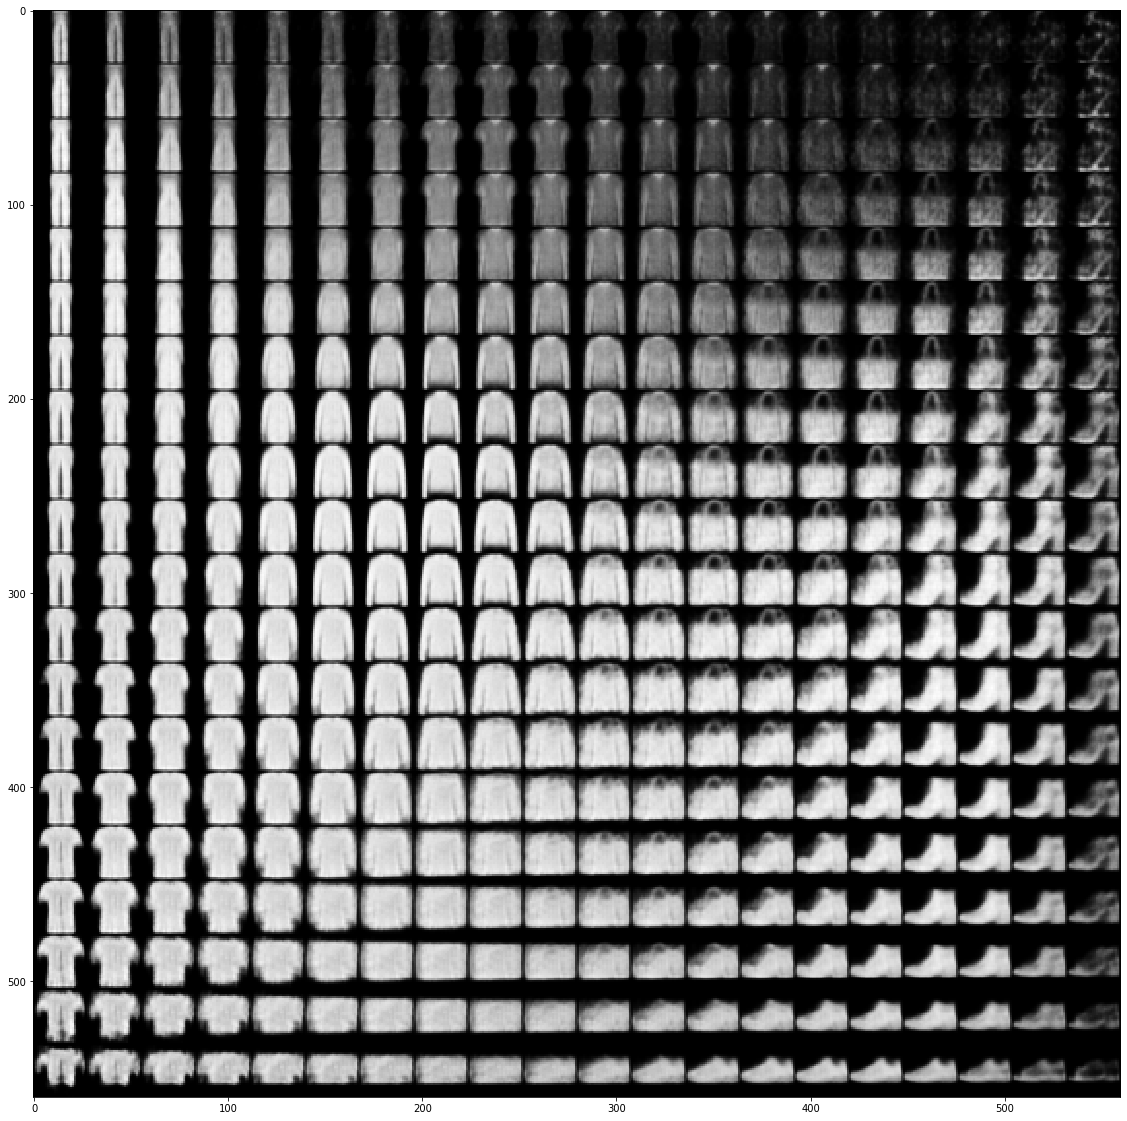

In [9]:
# Display a 2D manifold of the samples
n = 20  # figure with 20x20 samples
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values - can change values here to generate different things
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(20, 20))
plt.imshow(figure,cmap='gray')
plt.show()  


### VAE: Visualize latent space

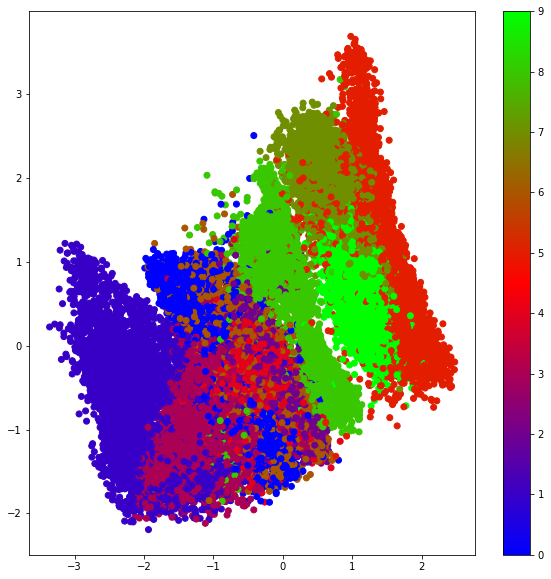

In [11]:
# Translate into the latent space
encoder = tf.keras.Model(input_img, z_mu)
x_valid_noTest_encoded = encoder.predict(train_x, batch_size=batch_size)
plt.figure(figsize=(10, 10))
plt.scatter(x_valid_noTest_encoded[:, 0], x_valid_noTest_encoded[:, 1], c=y_train, cmap='brg')
plt.colorbar()
plt.show()